In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import csv
import glob
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_data(path):
    def func(x):
        """Extracts input size from file name"""
        v = x.split(".")[-2].split("-")[-1]
        return int(v)
    
    data = {}

    for filename in glob.iglob(path):
        # extract name
        name = filename.replace("../", "").split(".")[0]

        # read file
        df = pd.read_csv(filename, index_col="Filename")

        # make column names lower-case and remove spaces
        df = df.rename(columns=lambda x: x.strip().lower())    

        # add encoding and message (tyencodepe) columns
        df['format'] = np.where(df.index.str.endswith(".ber"), 'BER', 'XER')
        df['message'] = np.where(df.index.str.contains("data-request"), 'data-request', 'data-response')

        # drop total
        df = df.drop(axis=1, columns=['total'])

        # rename average to the name of this data set
        df = df.rename(columns={"average": name})

        # create input-size parameter
        df['input-size'] = df.index.map(func)

        # save df
        data[name] = df
    
    return data

data = load_data("../*.csv")

# Encoding

In [4]:
encode_xml = data["encode-c"][data["encode-c"]["format"] == 'XER'].sort_values(
    by='input-size'
).drop(['bytes', 'format'], axis=1
      ).rename(columns={'encode-c': 'encode-c-xml'})

encoding = pd.merge(data["encode-python"], data["encode-c"], how='inner').drop(['bytes', 'format'], axis=1)
encoding = pd.merge(encoding, encode_xml, on=['message', 'input-size'], how='inner')
encoding = pd.merge(encoding, data["encode-java"], on=['message', 'input-size'], how='inner').drop(['format', 'bytes'], axis=1)
# encoding = pd.merge(encoding, data["encode-java10"], on=['message', 'input-size'], how='inner').drop(['format', 'bytes'], axis=1)

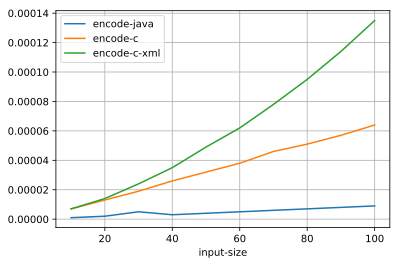

In [5]:
encoding[encoding['message'] == 'data-request'].sort_values(
    by='input-size'
).plot(
    x='input-size',
    y=[# 'encode-python', 
        'encode-java', 'encode-c', 'encode-c-xml'
    ],
    grid=True
)

,encode-python,message,input-size,encode-c,encode-c-xml,encode-java
11,0.003977,data-response,100,0.000075,0.000026,0.000011
12,0.008450,data-response,200,0.000144,0.000052,0.000018
13,0.011769,data-response,300,0.000214,0.000079,0.000027
14,0.016668,data-response,400,0.000287,0.000104,0.000037
15,0.020658,data-response,500,0.000366,0.000133,0.000046
16,0.025287,data-response,600,0.000434,0.000157,0.000054
17,0.029054,data-response,700,0.000503,0.000185,0.000064
18,0.033670,data-response,800,0.000571,0.000212,0.000074
19,0.037124,data-response,900,0.000639,0.000239,0.000082
10,0.042933,data-response,1000,0.000748,0.000261,0.000091


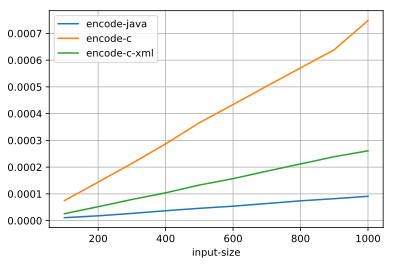

In [6]:
encoding[encoding['message'] == 'data-response'].sort_values(by='input-size').plot(
    x='input-size',
    y=['encode-java', 'encode-c', 'encode-c-xml', #'encode-python'
      ],
    grid=True
)
encoding[encoding['message'] == 'data-response'].sort_values(by='input-size')

# Decoding

In [7]:
decode_xml = data["decode-c"][data["decode-c"]["format"] == 'XER'].sort_values(
    by='input-size'
).drop(['bytes', 'format'], axis=1
      ).rename(columns={'decode-c': 'decode-c-xml'})

decoding = pd.merge(data["decode-python"], data["decode-c"], how='inner').drop(['bytes', 'format'], axis=1)
decoding = pd.merge(decoding, decode_xml, on=['message', 'input-size'], how='inner')
decoding = pd.merge(decoding, data["decode-java"], on=['message', 'input-size'], how='inner').drop(['format', 'bytes'], axis=1)
# decoding = pd.merge(decoding, data["decode-java10"], on=['message', 'input-size'], how='inner').drop(['format', 'bytes'], axis=1)

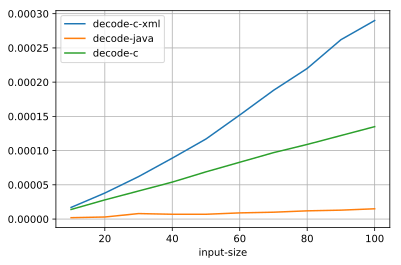

In [8]:
decoding[decoding['message'] == 'data-request'].sort_values(
    by='input-size'
).plot(
    x='input-size',
    y=['decode-c-xml', 'decode-java', 'decode-c',
       # 'decode-python',
      ],
    grid=True
)

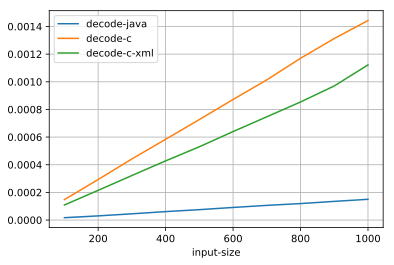

In [9]:
decoding[decoding['message'] == 'data-response'].sort_values(by='input-size').plot(
    x='input-size',
    y=['decode-java', 'decode-c', 'decode-c-xml', 
       #'decode-python'
      ],
    grid=True
)

## Message sizes

In [30]:
import converter, glob, os, re

In [67]:
files = glob.iglob("../message-*")
sizes = pd.DataFrame(columns=['message', 'input_size', 'format', 'size'])

sizes = []

for f in files:
    sizes.append({
        'size': int(os.stat(f).st_size),
        'format': f.split(".")[-1].upper(),
        'input-size': int(re.findall(r'\d+', f)[0]),
        'message': 'data-response' if 'data-response' in f else 'data-request'
    })
# sizes = pd.DataFrame(data=sizes)

In [80]:
df = pd.DataFrame(index=range(10, 110, 10), columns=converter.OUTPUT_FORMATS)
df # TODO

,ber,xer,per,jer,uper,gser
10,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
for s in sizes:
    if s['format'] == 'BER' and s['message'] == 'data-response':
        print(s)

{'size': 5331, 'format': 'BER', 'input-size': 100, 'message': 'data-response'}
{'size': 10631, 'format': 'BER', 'input-size': 200, 'message': 'data-response'}
{'size': 37131, 'format': 'BER', 'input-size': 700, 'message': 'data-response'}
{'size': 42431, 'format': 'BER', 'input-size': 800, 'message': 'data-response'}
{'size': 26531, 'format': 'BER', 'input-size': 500, 'message': 'data-response'}
{'size': 15931, 'format': 'BER', 'input-size': 300, 'message': 'data-response'}
{'size': 47731, 'format': 'BER', 'input-size': 900, 'message': 'data-response'}
{'size': 53031, 'format': 'BER', 'input-size': 1000, 'message': 'data-response'}
{'size': 21231, 'format': 'BER', 'input-size': 400, 'message': 'data-response'}
{'size': 31831, 'format': 'BER', 'input-size': 600, 'message': 'data-response'}
